In [20]:
import numpy as np
import pandas as pd 
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from collections import defaultdict
from tqdm.auto import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
mnist_trainset = datasets.MNIST(root='../data', train=True, download=False, transform=transforms.ToTensor())
mnist_testset = datasets.MNIST(root='../data', train=False, download=False, transform=transforms.ToTensor())

In [22]:
train_dataloader = DataLoader(mnist_trainset,batch_size=64,shuffle=True)
test_dataloader = DataLoader(mnist_testset,batch_size=64,shuffle=True)

In [58]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=6,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )
        
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=(5, 5),
            stride=(1, 1),
            padding=(0, 0),
        )
        
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=120,
            kernel_size=(4, 4),
            stride=(1, 1),
            padding=(0, 0),
        )
        self.linear1 = nn.Linear(120, 84)
        self.linear2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x)) #24d
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(
            self.conv3(x)
        )  # num_examples x 120 x 1 x 1 --> num_examples x 120
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return x

        

In [59]:
n_classes = len(mnist_trainset.classes)

In [60]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [61]:
lenet = LeNet()

In [62]:
print(lenet)

LeNet(
  (relu): ReLU()
  (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
)


In [63]:
def train(model,optimizer,criterion,train_dataloader,device,EPOCHS,evaluate_epoch=True):
    
    model = model.to(device)
    total = len(train_dataloader) * EPOCHS
    log = defaultdict(list)
    log["train_loss"] = []
    loss_a = []
    
    with tqdm(total=total,desc="Training") as tt:
        
        for epoch in range(EPOCHS):
            
            total_loss, batch_loss, batch_counts = 0, 0, 0
            
            for batch_idx, (data, target) in enumerate(train_dataloader):
                
                model.train()
                
                optimizer.zero_grad()
                batch_counts +=1
                
                out = model(data)
                
                loss = criterion(out, target)
                            
                loss.backward()
                
                total_loss += loss.item()
                
                optimizer.step()
                
                loss_a.append(loss.item())
                
            if evaluate_epoch:
                print(f"{epoch+1}/{EPOCHS}:")
                print(f"  - Train Loss: {np.mean(loss_a)}")
                log["train_loss"].append(total_loss / len(train_dataloader))
            tt.update()
            
        print("Done.")
        tt.close()
    return model, log
                

In [69]:
def test(model,criterion,test_dataloader,device):
    
    total = len(test_dataloader)
    loss_a = []
    
        
    with tqdm(total=total,leave=False,desc="Testing") as ee:
            
        test_loss, test_batch_loss, test_batch_counts = 0, 0, 0
        model.eval()
        for data, target in test_dataloader:
                
            test_batch_counts += 1
            with torch.no_grad():
                out = model.forward(data)
            
            loss = criterion(out,target)
            loss_a.append(loss.detach().cpu().numpy())
            test_batch_loss += loss.item()
            test_loss += loss.item()
            
        ee.update()
        
        print(f"  - Test Loss: {np.mean(test_loss)}")
            
        
            
        ee.close()
        
    return np.mean(loss_a)

In [70]:
criterion = torch.nn.CrossEntropyLoss()
EPOCHS = 20
opts = {
    'lr': 3e-4,
    'batch_size': 64
}
optimizer = torch.optim.Adam(lenet.parameters(), opts['lr'])

In [71]:
train(model=lenet,
    optimizer=optimizer,
    criterion=criterion,
    train_dataloader=train_dataloader,
    device=device,
    EPOCHS=EPOCHS)

Training:   0%|          | 0/18760 [00:00<?, ?it/s]

1/20:
  - Train Loss: 0.07982615072693207
2/20:
  - Train Loss: 0.0759800370839208
3/20:
  - Train Loss: 0.07241518785693837
4/20:
  - Train Loss: 0.06940734456653204
5/20:
  - Train Loss: 0.06673304888539945
6/20:
  - Train Loss: 0.06406645385336492
7/20:
  - Train Loss: 0.06159923783106817
8/20:
  - Train Loss: 0.05945473351845001
9/20:
  - Train Loss: 0.057381606123593186
10/20:
  - Train Loss: 0.055399234480110866
11/20:
  - Train Loss: 0.05354691390084651
12/20:
  - Train Loss: 0.05183530277070805
13/20:
  - Train Loss: 0.05014719132110968
14/20:
  - Train Loss: 0.04861726811115261
15/20:
  - Train Loss: 0.04711127359275762
16/20:
  - Train Loss: 0.04569027713291776
17/20:
  - Train Loss: 0.0443157401720603
18/20:
  - Train Loss: 0.043047751038963016
19/20:
  - Train Loss: 0.04180576612045598
20/20:
  - Train Loss: 0.040687713570008326
Done.


(LeNet(
   (relu): ReLU()
   (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
   (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
   (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (conv3): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
   (linear1): Linear(in_features=120, out_features=84, bias=True)
   (linear2): Linear(in_features=84, out_features=10, bias=True)
 ),
 defaultdict(list,
             {'train_loss': [0.07982615072693207,
               0.07213392344090952,
               0.06528548940297352,
               0.060383814695313065,
               0.056035866160869106,
               0.05073347869319226,
               0.04679594169728764,
               0.04444320333012288,
               0.04079658696473862,
               0.03755788968876997,
               0.03502370810820294,
               0.033007580339185036,
               0.02988985392592921,
               0.028728266381710738,
               0.02602735033522778,
           

In [72]:
test(model=lenet,
    criterion=criterion,
    test_dataloader=test_dataloader,
    device=device)

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

  - Test Loss: 8.235335960547673


0.052454364

In [73]:
with torch.no_grad():
    true = 0
    false = 0
    for index in range(len(mnist_testset)):
        
        item = mnist_testset[index]
        image=item[0].reshape([1,1,28,28])
        true_target = item[1]
        
        pred = lenet(image)
        predicted_class = np.argmax(pred)
        
        if predicted_class == true_target:
            true +=1
        else:
            false +=1
            
    accuracy = (100 * true)/len(mnist_testset)
    
print(true)
print(false)
print(accuracy)

9843
157
98.43


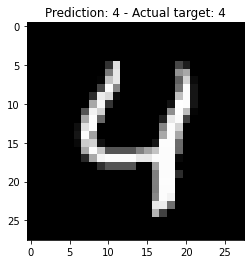

In [57]:
with torch.no_grad():
    index = 4
    
    
    item = mnist_testset[index]
    image=item[0].reshape([1,1,28,28])
    true_target = item[1]
    
    
    prediction = lenet(image)
    
    predicted_class = np.argmax(prediction)
    
    image = image.reshape(28, 28, 1)
    
    # Show result
    plt.imshow(image, cmap='gray')
    plt.title(f'Prediction: {predicted_class} - Actual target: {true_target}')
    plt.show()

In [79]:
torch.save(lenet, f"lenet_{accuracy}.pt")

In [80]:
model = torch.load(f"lenet_{accuracy}.pt")
model.eval()

LeNet(
  (relu): ReLU()
  (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
  (linear1): Linear(in_features=120, out_features=84, bias=True)
  (linear2): Linear(in_features=84, out_features=10, bias=True)
)